In [1]:
!pip install -U "tensorflow>=2.10.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 25.1 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [3]:
!pip install remotezip tqdm opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [4]:
#required libraries to preprocess the dataset
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import remotezip as rz

import tensorflow as tf
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

In [5]:
#ucf dataset url
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

In [6]:
#function to examin the contain of zip file
def list_files_from_zip_url(zip_url):
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [7]:
#example of the content of zip file
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

In [9]:
#function to retrieve the class name contain in file itself then creating then the direcotry to store of data of same class

def get_class(fname):

  return fname.split('_')[-3]

def get_files_per_class(files):

  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

In [10]:
#no of class and video pr class to use
NUM_CLASSES = 5
FILES_PER_CLASS =60

In [11]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

In [12]:
#information about the dataset
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 101
Num videos for class[0]: 145


In [14]:
#subset of classes present wthin the dataset
def select_subset_of_classes(files_for_class, classes, files_per_class):

  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

In [15]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam']

In [16]:
#define the function that divide the data into train,test and valid
def download_from_zip(zip_url, to_dir, file_names):

  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

The following function returns the remaining data that hasn't already been placed into a subset of data. It allows you to place that remaining data in the next specified subset of data.

In [17]:
def split_class_lists(files_for_class, count):

  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

In [18]:
def download_ucf_101_subset(zip_url, num_classes, splits, download_dir):

  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    random.shuffle(files_for_class[cls])

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

In [19]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ucf_101_subset(URL,
                                       num_classes = NUM_CLASSES,
                                       splits = {"train": 30, "val": 10, "test": 10},
                                       download_dir = download_dir)

train :


100%|██████████| 150/150 [00:09<00:00, 15.03it/s]


val :


100%|██████████| 50/50 [00:02<00:00, 17.86it/s]


test :


100%|██████████| 50/50 [00:02<00:00, 17.21it/s]


In [20]:
#info of train,test and val dataset
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 250


In [21]:
!find ./UCF101_subset

./UCF101_subset
./UCF101_subset/test
./UCF101_subset/test/ApplyLipstick
./UCF101_subset/test/ApplyLipstick/v_ApplyLipstick_g01_c04.avi
./UCF101_subset/test/ApplyLipstick/v_ApplyLipstick_g25_c02.avi
./UCF101_subset/test/ApplyLipstick/v_ApplyLipstick_g06_c05.avi
./UCF101_subset/test/ApplyLipstick/v_ApplyLipstick_g21_c01.avi
./UCF101_subset/test/ApplyLipstick/v_ApplyLipstick_g09_c02.avi
./UCF101_subset/test/ApplyLipstick/v_ApplyLipstick_g15_c05.avi
./UCF101_subset/test/ApplyLipstick/v_ApplyLipstick_g22_c02.avi
./UCF101_subset/test/ApplyLipstick/UCF101
./UCF101_subset/test/ApplyLipstick/v_ApplyLipstick_g02_c03.avi
./UCF101_subset/test/ApplyLipstick/v_ApplyLipstick_g18_c04.avi
./UCF101_subset/test/ApplyLipstick/v_ApplyLipstick_g14_c01.avi
./UCF101_subset/test/BalanceBeam
./UCF101_subset/test/BalanceBeam/v_BalanceBeam_g17_c05.avi
./UCF101_subset/test/BalanceBeam/v_BalanceBeam_g05_c01.avi
./UCF101_subset/test/BalanceBeam/v_BalanceBeam_g22_c02.avi
./UCF101_subset/test/BalanceBeam/v_BalanceBeam

In [22]:
#create frames from each viedo(extracting the frames) it will choose randomly choose from frames
def format_frames(frame, output_size):

  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [23]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):

  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [24]:
#the FrameGenerator helps in preparing and organizing video data to be easily used by TensorFlow
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [25]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 4


In [26]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (10,224, 224, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training=True),
                                          output_signature = output_signature)
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10, training=True),
                                          output_signature = output_signature)

In [27]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


In [28]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(4, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)


In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [30]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)
Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validation labels: (2,)


These Classification model that uses a

pre-trained EfficientNet trains to high accuracy in a few minutes
https://arxiv.org/abs/1905.11946

In [31]:
#frames are ready and convert into tensor to feed into the network  with corresponding labels
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(10),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

model.fit(train_ds,
          epochs = 10,
          validation_data = val_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
     75/Unknown 173s 62ms/step - accuracy: 0.5216 - loss: 1.6180

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


75/75 ━━━━━━━━━━━━━━━━━━━━ 213s 596ms/step - accuracy: 0.5236 - loss: 1.6115 - val_accuracy: 0.9200 - val_loss: 0.5074
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - accuracy: 0.9919 - loss: 0.4043 - val_accuracy: 0.9400 - val_loss: 0.3007
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.9987 - loss: 0.1849 - val_accuracy: 1.0000 - val_loss: 0.2232
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 1.0000 - loss: 0.1221 - val_accuracy: 1.0000 - val_loss: 0.1827
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 1.0000 - loss: 0.0954 - val_accuracy: 0.9200 - val_loss: 0.1852
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 1.0000 - loss: 0.0736 - val_accuracy: 0.9600 - val_loss: 0.1484
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 1.0000 - loss: 0.0483 - val_accuracy: 0.9200 - val_loss: 0.1646
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 1.0000 - loss: 0.0468 - val_accuracy: 0.9400 - val_lo

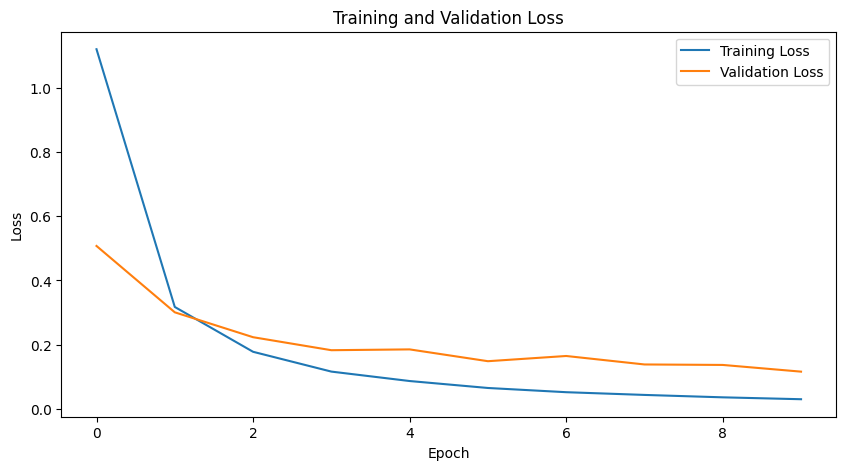

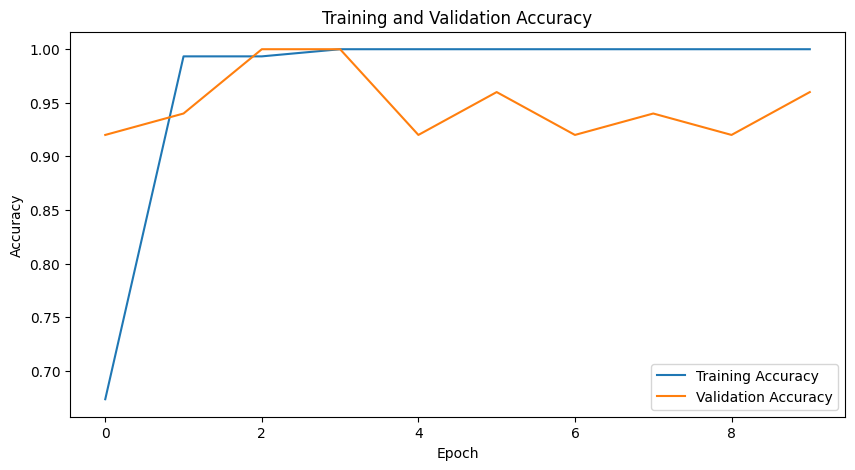

In [32]:
#graph for loss and accuracy both valdations

import matplotlib.pyplot as plt
history = model.history

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [33]:
# Evaluating  the model on the test dataset
test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], 10, training=False),
                                          output_signature = output_signature)
test_ds = test_ds.batch(2)

loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 337ms/step - accuracy: 0.8886 - loss: 0.1939
Test Loss: 0.1727
Test Accuracy: 0.9200


In [34]:
# prompt: generate classification report for the classes

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Assuming 'model' and 'test_ds' are defined as in the previous code

# Get predictions for the test dataset
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from the test dataset
y_true = []
for _, labels in test_ds:
  y_true.extend(labels.numpy())

# Generate classification report
class_names = sorted(set(p.name for p in subset_paths['train'].iterdir() if p.is_dir())) # Get class names
report = classification_report(y_true, y_pred_classes, target_names=class_names)

print(report)

25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 261ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


                precision    recall  f1-score   support

ApplyEyeMakeup       0.82      0.90      0.86        10
 ApplyLipstick       0.89      0.80      0.84        10
       Archery       0.91      1.00      0.95        10
  BabyCrawling       1.00      0.90      0.95        10
   BalanceBeam       1.00      1.00      1.00        10

      accuracy                           0.92        50
     macro avg       0.92      0.92      0.92        50
  weighted avg       0.92      0.92      0.92        50



In [35]:
# Load the model
# Save the model after training
model.save('ucf101_model.keras')

In [36]:
import warnings
warnings.filterwarnings("ignore")

In [37]:
!pip install -q mediapy

import mediapy as media

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.6 MB/s eta 0:00:00


In [38]:
# import numpy as np
# import tensorflow as tf
# import cv2
# import random

# # Define a function to extract frames from video
# def frames_extraction(video_path, num_frames, output_height, output_width, frame_step=15):
#     frames = []
#     cap = cv2.VideoCapture(video_path)
#     video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

#     # Calculate the required starting frame based on the frame step
#     max_start_frame = max(0, video_length - (num_frames - 1) * frame_step)
#     start_frame = random.randint(0, max_start_frame)

#     cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

#     for _ in range(num_frames):
#         ret, frame = cap.read()
#         if ret:
#             frame = cv2.resize(frame, (output_width, output_height))
#             frames.append(frame)
#         else:
#             frames.append(np.zeros((output_height, output_width, 3)))  # Placeholder if frame is not available
#         cap.set(cv2.CAP_PROP_POS_FRAMES, cap.get(cv2.CAP_PROP_POS_FRAMES) + frame_step - 1)

#     cap.release()
#     return np.array(frames)

# # Load your pre-trained model
# base_model = tf.keras.models.load_model('/content/ucf101_model.keras')

# # Define the class labels
# CLASSES_LIST = ['ApplyLipstick', 'BalanceBeam', 'BabyCrawling', 'Archery', 'ApplyEyeMakeup', 'Class6', 'Class7', 'Class8', 'Class9', 'Class10'] # Updated with placeholder class names

# # ... (rest of the code) ...
# # Extract frames from the video
# video_path = "/content/End_of_a_jam.ogv"  # Update with the actual video path
# frames = frames_extraction(video_path, num_frames=10, output_height=240, output_width=240)
# frames_batch = np.expand_dims(frames, axis=0)  # Shape becomes: (1, 10, 240, 240, 3)

# # Make predictions
# predictions = base_model.predict(frames_batch)

# # Get the predicted class probabilities
# predicted_class_probs = predictions[0]

# # Get the predicted class
# predicted_class = CLASSES_LIST[np.argmax(predictions)]

# # Print the predicted class and its probabilities
# print(f"Predicted class: {predicted_class}")
# print("Class probabilities:")
# for idx, prob in enumerate(predicted_class_probs):
#     print(f"{CLASSES_LIST[idx]}: {prob*100:.2f}%")
# from matplotlib import animation
# # Optionally, display the video frames
# # Ensure you have the appropriate media display function for showing video
# import matplotlib.pyplot as plt

# # Function to extract frames from video
# def frames_extraction(video_path, num_frames, output_height, output_width, frame_step=15):
#     frames = []
#     cap = cv2.VideoCapture(video_path)
#     video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

#     max_start_frame = max(0, video_length - (num_frames - 1) * frame_step)
#     start_frame = random.randint(0, max_start_frame)

#     cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

#     for _ in range(num_frames):
#         ret, frame = cap.read()
#         if ret:
#             frame = cv2.resize(frame, (output_width, output_height))
#             frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying with matplotlib
#         else:
#             frames.append(np.zeros((output_height, output_width, 3)))  # Placeholder if frame is not available
#         cap.set(cv2.CAP_PROP_POS_FRAMES, cap.get(cv2.CAP_PROP_POS_FRAMES) + frame_step - 1)

#     cap.release()
#     return np.array(frames)

# # Display the frames using matplotlib
# def show_video(frames, fps=3):
#     fig, ax = plt.subplots()
#     ims = []
#     for frame in frames:
#         im = ax.imshow(frame, animated=True)
#         ims.append([im])
#     ani = animation.ArtistAnimation(fig, ims, interval=1000 // fps, blit=True, repeat_delay=1000)

#     # Use PillowWriter for smooth display
#     ani.save('/content/temp_video.gif', writer='pillow', fps=fps)  # Save animation as GIF
#     plt.show()

# show_video(frames, fps=3)
